# Classification of Heart Disease Using K-Nearest Neighbor

In [ ]:
# Load packages that will be used.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(gridExtra)

## Introduction
Many people die of cardiovascular diseases without knowing they have a problem with their heart. Unexpected deaths as such can be prevented with early diagnosis of cardiovascular issues and proper medication. When a patient comes to the hospital, there are many pieces of data such as symptoms, test results, and personal information that can help cariologists predict if heart disease is present. In this project, we are trying to answer: **Can existing cardiovascular patient data** (specifically, `age`, `ca`, `cp`, `oldpeak`,`restecg`, `slope`, `thal` and `thalach` in the dataset) **and the KNN classification algorithm be used to detect the presence or absence of heart disease in new patients who enter the hospital? If so, how accurate could it be and how can we use it correctly in practice?** The heart [disease dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) we are using is obtained from the UCI machine learning repository . It contains 303 patient instances and 14 attributes collected from Cleveland. Each row of the dataset corresponds to one patients personal and medical information upon entry to the hospital. 

This dataset contains the following variables: 
- `sex`: 1 = male; 0 = female
- `cp`: chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic); 
- `trestbps`: resting blood pressure (in mm Hg on admission to hospital); 
- `chol`: serum cholesteral in mg/dl; 
- `fbs`: fasting blood sugar > 120 mg/dl (1 = true, 2 = false); 
- `restecg`: resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality; 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria); 
- `thalach`: maximum heart rate achieved; 
- `exang`: exercise induced angina (1 = yes, 0 = no); 
- `oldpeak`: ST depression induced by exercise relative to rest; 
- `slope`: the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping); 
- `ca`: number of major vessels (0-3) colored by flourosopy; 
- `thal`: type of defect (3 = normal, 6 = fixed defect, 7 = reversable defect); 
- `num`: diagnosis of heart disease (angiographic disease status) (0 = absence, 1, 2, 3, 4 = presence)

Our target variable would be `num`, which we later renamed as `diagnosis`. We selected `age`, `ca`, `cp`, `oldpeak`,`restecg`, `slope`, `thal` and `thalach` as predictors to determine heart disease status.

## Methods and Results
### 1. Read the Original Dataset on the Web

In [43]:
# Set the value of seed to ensure reproducibility
set.seed(200)

# Read the dataset from the web into a tibble dataframe
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
heart_cleve <- read_csv(url,col_names = FALSE)
# head(heart_cleve)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



### 2. Data Wrangling
> The columns must be renamed from the placeholders that R created, to names that are meaningful and human-readable. Here, we replaced them with the same names that were used in the original dataset, with the exception of `diagnosis` for ease, which was originally called `num`.
Additionally, `ca` and `thal` were converted to numeric values for use in the KNN algorithm.

In [44]:
# Rename the column names and Format the column types
heart_cleve <- rename(heart_cleve, age = X1,
               sex = X2,
               cp = X3,
               trestbps = X4,
               chol = X5,
               fbs = X6,
               restecg = X7,
               thalach = X8,
               exang = X9,
               oldpeak = X10,
               slope = X11,
               ca = X12,
               thal = X13,
               diagnosis = X14) %>% 
            mutate(ca = as.numeric(ca),thal = as.numeric(thal))
# head(heart_cleve)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


> The column `diagnosis` originally has the values 0-4, however, we are looking at presence versus absence of heart disease, which only requires 2 values. We wrangled the data so that 0 indicates the absence of heart disease and 1 indicates the presence of heart disease.

In [45]:
# Wrangle the `diagnosis` column: 0 indicates absence of heart disease and 1 indicates presence of heart disease.

heart_cleve$diagnosis[heart_cleve$diagnosis==2] <- 1
heart_cleve$diagnosis[heart_cleve$diagnosis==3] <- 1
heart_cleve$diagnosis[heart_cleve$diagnosis==4] <- 1
heart_cleve <- heart_cleve %>% mutate(diagnosis = as_factor(diagnosis))
head(heart_cleve)

# Source: https://www.geeksforgeeks.org/how-to-replace-specific-values-in-column-in-r-dataframe/

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


*Table 1: Data table after wrangling (only showing the first 6 rows)*

### 3. Data Splitting
The data will now be split into training and testing sets so that we can train and explore the data without compromising our accuracy results and to be able to test the efficacy of our model.

In [46]:
# Split the dataset into training and test sets
set.seed(200)

heart_split <- initial_split(heart_cleve,prop=0.75,strata=diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

### 4. Data Exploration and Predictors Selection
The training data will then be used to explore the data which helps determine if we need to take additional steps to wrangle the data and helps with our predictors selection.   
#### Summary statistics of the Training data
> Below we found that there is a fairly equal distribution of the observations for the two diagnoses, therefore further steps do not have to be taken to balance them.

In [47]:
# Summary Statistics of the training data

# Number of observations in each class
heart_sum_class <- heart_train %>% 
                group_by(diagnosis) %>%
                summarise(n=n(), percent=n()/nrow(heart_train)*100)
heart_sum_class

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n,percent
<fct>,<int>,<dbl>
0,123,54
1,105,46


*Table 2: Number of and percentage of observations in each class*

> The following tibble gives us a thorough overview of the variables we are working with in a simple fashion. This can help us with understanding the predictors we are using and whether we need to do further wrangling.

In [1]:
# Summary statistics of predictor variables used in analysis
options(digits=2)
heart_percentile <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(quantile,na.rm = TRUE) 

heart_1stQ <- heart_percentile %>%
                select('25%') %>%
                t()%>%
                as.vector()

heart_3rdQ <- heart_percentile %>%
                select('75%') %>%
                t() %>%
                as.vector()

heart_mean <- heart_train%>% 
                    select(-diagnosis) %>%
                    map_df(mean,na.rm = TRUE)

heart_min <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(min,na.rm = TRUE)

heart_max <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(max,na.rm = TRUE)

heart_median <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(median,na.rm = TRUE)

heart_range <- heart_max - heart_min

heart_missing <- colSums(is.na(heart_train %>% select(-diagnosis)))
# Source: https://stackoverflow.com/questions/26273663/r-how-to-total-the-number-of-na-in-each-col-of-data-frame

heart_sum_pred <- rbind(heart_min, heart_1stQ, heart_median,heart_mean, heart_3rdQ, heart_max, heart_range, heart_missing) %>%
                    mutate(Statistics = c('Min','First Quartile','Median','Mean','Third Quartile','Max','Range','# of Missing Value'),.before = age)
heart_sum_pred

ERROR: Error in heart_train %>% select(-diagnosis) %>% map_df(quantile, na.rm = TRUE): could not find function "%>%"


*Table 3: Summary statistics of variables in the training set*

> The table above allows us to analyze the distribution of each variable and the possbility of outliers. By exploring the tendency of the data, it will help us to decide variables are suitable to be used and if they are effecting the data more than others. 

#### Visualization of the Training data
> Density plot was used to visualize the training data and to help with predictors selection. We know that the less overlap between different classes on the density curve would imply better prediction power of a variable, as every numeric value more closely belongs to a specific class.

In [2]:
options(repr.plot.width=12,repr.plot.height = 12)
heart_train %>%
    pivot_longer(cols = -diagnosis, names_to = 'variables', values_to = 'value')  %>% 
    ggplot(aes(value, fill = diagnosis)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ variables, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 18))

ERROR: Error in heart_train %>% pivot_longer(cols = -diagnosis, names_to = "variables", : could not find function "%>%"


*Figure 1: Density plots of all variables in the training set*

According to the density plot and literature review on heart disease, we chose `age`, `ca`, `cp`, `oldpeak`,`restecg`, `slope`, `thal` and `thalach` as our predictors. The density plots of these variables overlap less between the two classes compared to others. The less the classes overlap indicates it being a better predictor for the diagnosis of heart disease.

> Since both `ca` and `thal` have missing values (according to *Table 3*), wrangling is needed to filter out the observations with missing values in both the training and test sets.

In [51]:
# Filter out observations with missing values
heart_train_filtered <- heart_train %>% filter(!is.na(ca)) %>% filter(!is.na(thal))
heart_test_filtered <- heart_test %>% filter(!is.na(ca)) %>% filter(!is.na(thal))

# heart_train_filtered
# heart_test_filtered


### 5. Model Training and Model Tuning using Cross-validation

Next, we will determine the best K value to use to achieve maximum accuracy through a methodical approach outlined below.

[1] 49 50


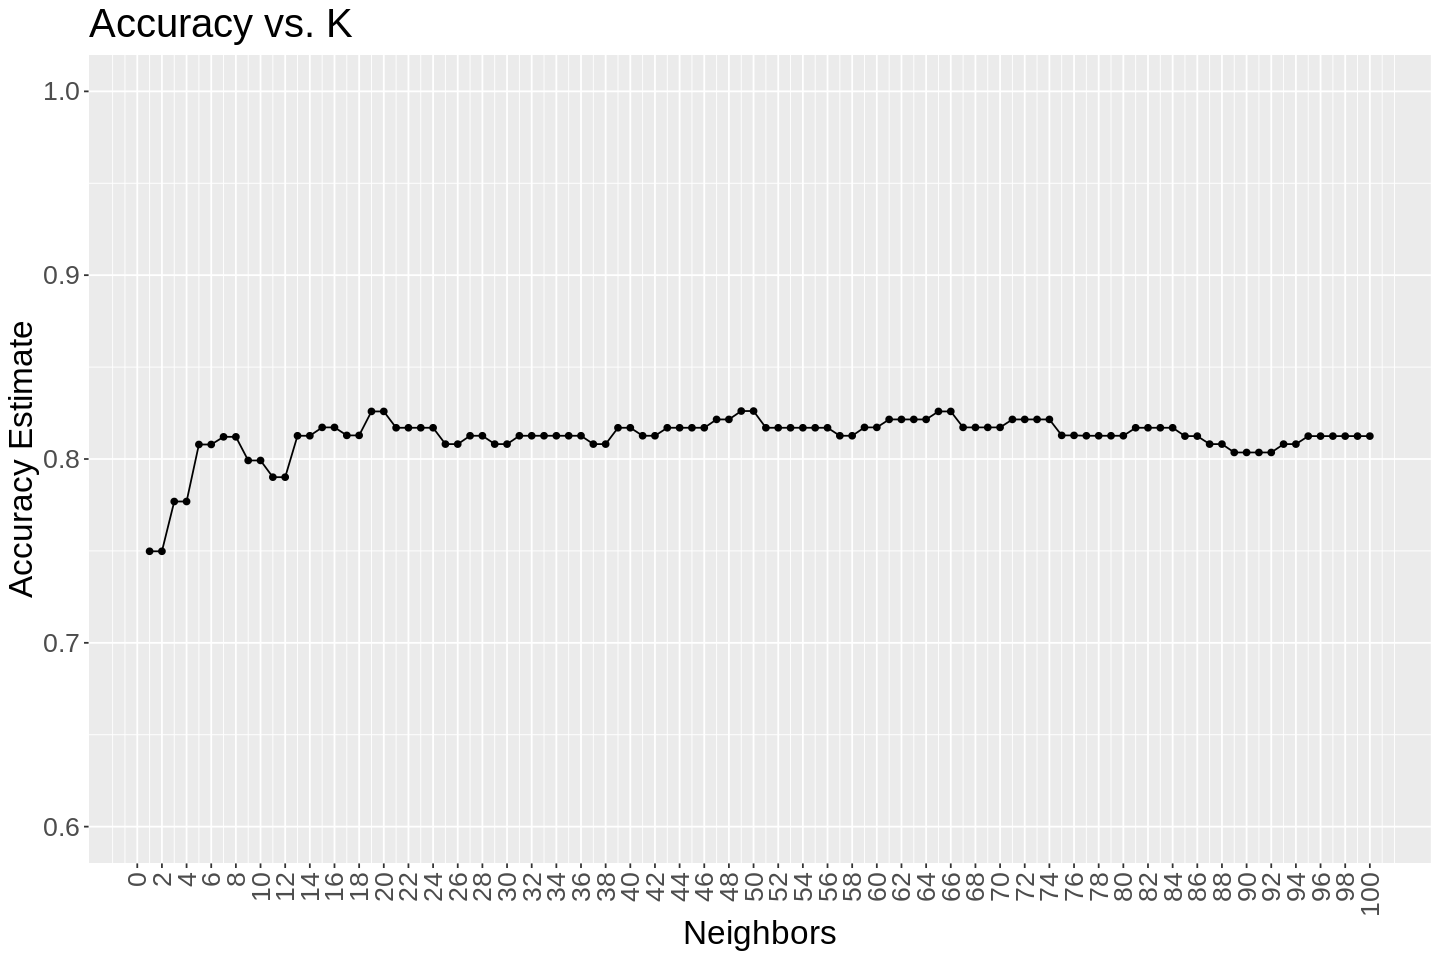

In [53]:
set.seed(200)
# Create the recipe that specifies class label and predictors, as well as preprocessing steps for all variables.
heart_recipe <- recipe(diagnosis ~ age + ca + cp + oldpeak + restecg + slope + thal+ thalach, data = heart_train_filtered) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())
# heart_recipe


# Create a KNN model specification
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")
# heart_tune


# Split the training data for cross-validation
heart_vfold <- vfold_cv(heart_train_filtered, v = 10, strata = diagnosis)


# Create a dataframe with a neighbors variable that contains the sequence of values of K to try
k_vals <- tibble(neighbors=seq(from = 1, to = 100, by = 1))


# Create a workflow to train KNN classifiers and estimate the classifier accuracy for a range of K values.
heart_results <- workflow() %>%
                    add_recipe(heart_recipe) %>%
                    add_model(heart_tune) %>%
                    tune_grid(resamples = heart_vfold, grid = k_vals) %>%
                    collect_metrics()
# heart_results


# Filter the accuracy metric of classifers trained with different value of K
accuracies <- heart_results %>%
                    filter(.metric == "accuracy")
# head(accuracies)


# Create a plot for accuracy vs. K
options (repr.plot.width = 12, repr.plot.height = 8)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 100, by = 2)) +  
      scale_y_continuous(limits = c(0.6, 1.0), breaks = seq (0.4, 1, by = 0.1)) +
      theme(text = element_text(size = 20),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
      ggtitle('Accuracy vs. K')
accuracy_vs_k

*Figure 2: Estimated prediction accuracy for each value of K (number of neighbors)*

#### 6. Model Testing and Performance Evaluation

Finally, we will use our optimal K value obtained above to test our model against the testing data. The accuracy output will let us know how good our classifier is, and whether it is reasonable to use it in a healthcare setting where the diagnosis of heart disease would be an urgent and important conclusion that requires high accuracy.

In [56]:
# Pulling the optimal value of K
best_k <- accuracies %>%
            filter(mean==max(mean))%>%
            slice(1) %>%
            pull(neighbors)
# print(best_k)


# Create a KNN model specification with the optimal K
heart_best <- nearest_neighbor (weight_func = 'rectangular', neighbors = best_k) %>%
                set_engine ('kknn') %>%
                set_mode ('classification')
# heart_best

# Create a workflow to train KNN classifiers
heart_fit <- workflow () %>%
                add_recipe (heart_recipe) %>%
                add_model (heart_best) %>%
                fit (data = heart_train_filtered)
# heart_fit


# Predict the labels of the test set
heart_diagnosis_pred <- predict(heart_fit, heart_test_filtered) %>%
                            bind_cols(heart_test_filtered) 


# Collect evaluation metrics -- Accuracy
heart_accuracy <- heart_diagnosis_pred %>%
                        metrics(truth = diagnosis, estimate = .pred_class)%>%
                        filter(.metric == 'accuracy') %>%
                        select(.estimate) %>%
                        pull()

paste("The estimated Accuracy is:", as.character(heart_accuracy))


# Present the Confusion Matrix
confusion <- heart_diagnosis_pred %>%
                conf_mat(truth = diagnosis, estimate = .pred_class)
paste("Confusion Matrix:")
confusion

[1] "The estimated Accuracy is: 0.878378378378378"

[1] "Confusion Matrix:"

          Truth
Prediction  0  1
         0 38  7
         1  2 27

#### 7. Visualizing the Predition results

Since humans register data well visually, we have plotted our prediction accuracy.

In [58]:
# To add an index column to the data frame.
heart_diagnosis_pred$index <- 1:nrow(heart_diagnosis_pred)
head(heart_diagnosis_pred)

# Source: https://www.statology.org/add-index-column-to-data-frame-r/

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis,index
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1,1
0,66,0,1,150,226,0,0,114,0,2.6,3,0,3,0,2
0,69,0,1,140,239,0,0,151,0,1.8,1,2,3,0,3
0,64,1,3,140,335,0,0,158,0,0.0,1,0,3,1,4
0,44,1,3,130,233,0,0,179,1,0.4,1,0,3,0,5
0,61,1,3,150,243,1,0,137,1,1.0,2,0,3,0,6


*Table 4: Data table with an index column*

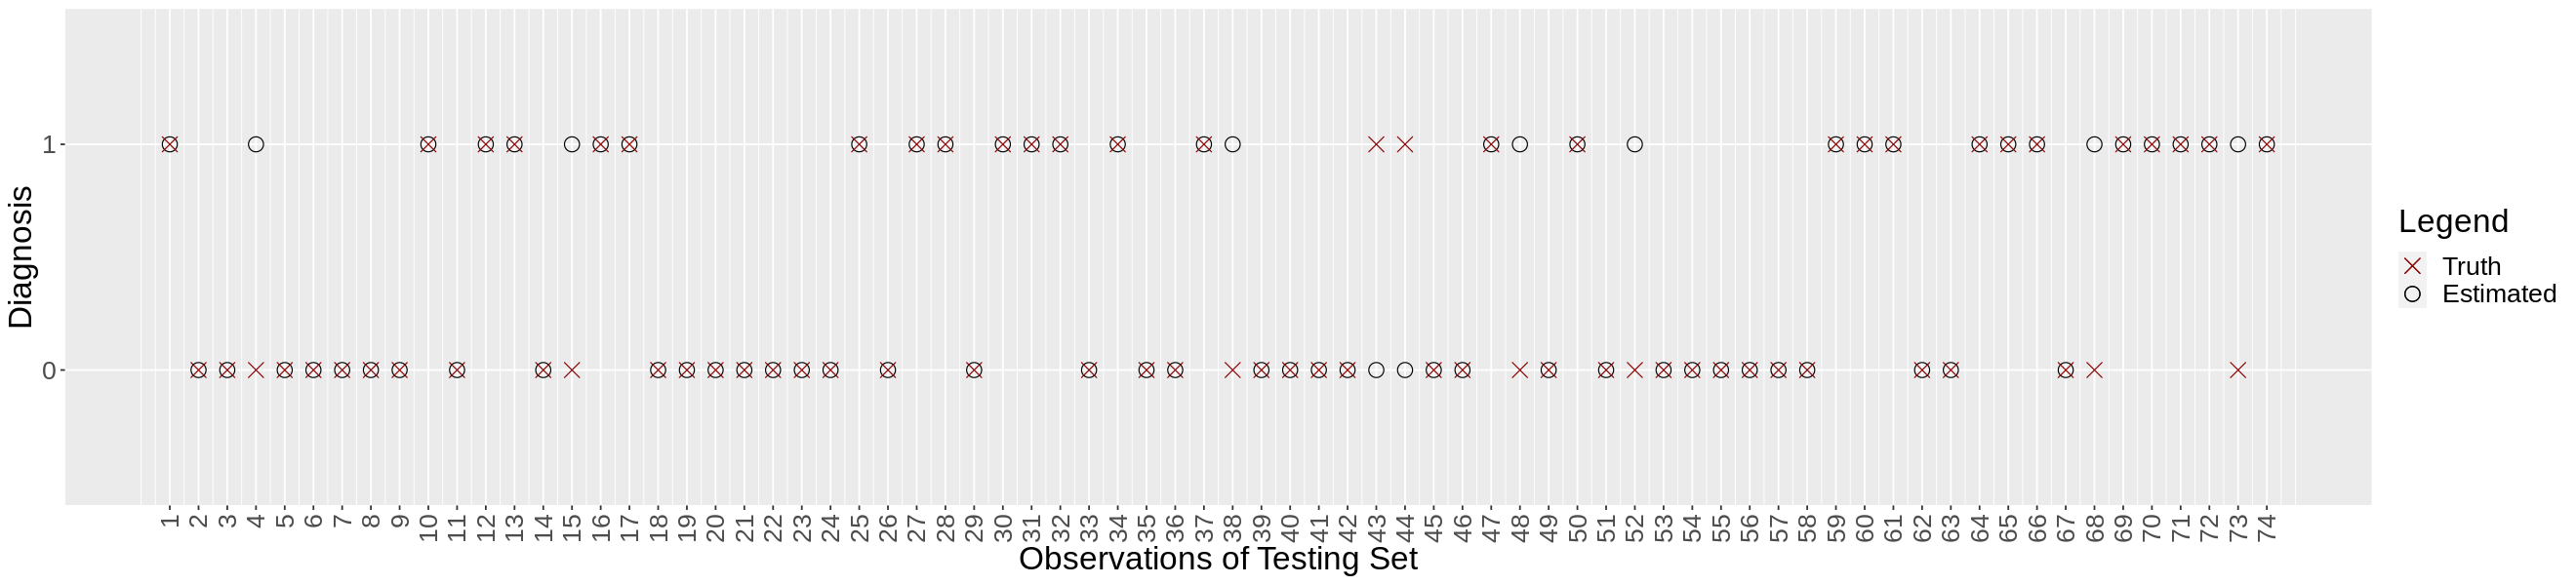

In [59]:
options(repr.plot.width=22,repr.plot.height=5)

colors <- c("Truth" = "black", "Estimated" = "#8B0000")
shapes <- c("truth" = 1, "estimated" = 4)
mapping <- ggplot(heart_diagnosis_pred,aes(x=index)) +
            geom_point(aes(y=diagnosis, color= 'Truth',shape='truth'),size=4)+
            geom_point(aes(y=.pred_class, color='Estimated',shape='estimated'),size=4)+
            scale_x_continuous(breaks=1:nrow(heart_diagnosis_pred)) +
            labs(x='Observations of Testing Set',y='Diagnosis',shape="",color="")+
            scale_color_manual(name="Legend", labels=c("Truth","Estimated"),values=colors)+
            scale_shape_manual(name="Legend", labels=c("Truth","Estimated"),values=shapes)+
            theme(text=element_text(size=20), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
mapping

# Source: 
# http://www.sthda.com/english/wiki/r-plot-pch-symbols-the-different-point-shapes-available-in-r
# https://stackoverflow.com/questions/12410908/combine-legends-for-color-and-shape-into-a-single-legend
# https://community.rstudio.com/t/adding-manual-legend-to-ggplot2/41651/4

*Figure 3: Visulization of prediction results*

## Discussion

We have created a classifier to answer the question: can existing cardiovascular patient data and the KNN classification algorithm be used to detect the presence or absence of heart disease in new patients who enter the hospital? Using the K Nearest Neighbors algorithm that predicts the presence or absence of heart disease with predictors, `age`, `ca`, `cp`, `restecg`, `slope`, `thalach` and `oldpeak`, we were able to answer this question. Determining an optimal K value of 43, our classifier returned an estimated accuracy of 87.8%. This is a mediocre accuracy, especially since the implications of the classifier predicting incorrectly can be fatal. Upon initial examination of the dataset itself, the variables included seemed promising and we expected that the classifier would have a high accuracy. For instance, the potential predictors of chest pain type, age, exercise induced angina, type of defect, and resting electrocardiogram results appeared to be closely related to whether the patient would have a heart defect or not. Note that this conclusion was made purely from a qualitative perspective, using common knowledge.Upon consultation with the literature, resting electrocardiographic results is a reliable predictor of heart diseases as it can detect problems by measuring electrical activity when the heart contracts (Ashley et al., 2001). Once we conducted our own exploratory data analysis, it became clear that the majority of these predictors were formatted as categorical variables that are not conducive to the KNN algorithm. We decided to use the resting electrocardiographic results due to the research we did, and others from the density plot that we created for exploratory data visualization. At this point, our expectations shifted to a less optimistic view of our results. Knowing that many of the predictors that we intuitively felt were strongly correlated with heart disease were not able to be used, we expected a lower accuracy rate. The inability to use categorical variables in our classifier is the main limitation of this report. In the future, it would be useful to ask what other numerical data could be used as strong predictors for heart disease. These could then be entered into a new dataset and tested for accuracy. The hope would be a higher accuracy estimate, where the classifier could potentially be used to build support systems to help clinicians to make better decisions on when to take precautionary steps due to suspected heart disease.

## References

Ashley, E. A., Raxwal, V., & Froelicher, V. (2001, August 1). An evidence-based review of the resting electrocardiogram as a screening technique for heart disease. ScienceDirect. https://www.sciencedirect.com/science/article/pii/S0033062001000196

Fernandez, M. L., & Webb, D. (2008). The LDL to HDL Cholesterol Ratio as a Valuable Tool to Evaluate Coronary Heart Disease Risk. Journal of the American College of Nutrition, 27(1), 1–5. https://doi.org/10.1080/07315724.2008.10719668

Pedoe, H. D. (1978, June 1). Predictability of sudden death from resting electrocardiogram. Effect of previous manifestations of coronary heart disease. Heart. https://heart.bmj.com/content/40/6/630.short

(DELETE?) Roland, J. (2017, January 30). Serum Cholesterol: Understanding Your Levels. Healthline. https://www.healthline.com/health/serum-cholesterol#results (DELETE?)

## Expected Outcomes and Significance (Not included in the report, just for reference)
We are expecting that the medical information that can be readily collected from the patients together with the classifier built under the KNN algorithm can facilitate the diagnosis and prediction of heart diseases. If our project can support the above finding, we will be able to draw insights into building decision support systems to help clinicians to make better decisions on the necessity to take precautionary steps. Future questions would be what other relevant variables can be included in the model and how we could further improve the prediction accuracy of the classifier.

The grid below helps us visualize the correlation between the variables we have decided to use to see how they might interact with each other to create our prediction output. It will  help us understand the significance of each predictor in our model. 